In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from glob import glob
from tqdm import tqdm
import xarray as xr
import os, sys
import scipy
import pandas as pd
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA
from scipy import stats

from scipy import interpolate

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

from allenAnalysis.utils import *

%matplotlib ipympl

In [2]:
np.median(np.arange(-25,25))

-0.5

In [3]:
from allenAnalysis.icsd import StandardCSD

In [4]:
import matplotlib

font = {'size'   : 12}

matplotlib.rc('font', **font)

In [5]:
matplotlib.rcParams['savefig.pad_inches'] = 0

In [47]:
def gaussian(x,sig):

    curve = 1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x) / sig, 2.0) / 2)

    curve /= np.max(curve)
    
    return curve

In [7]:
signals_stim = []
correlations_stim = []
averagedSignals_stim = []
averagedCorrelations_stim = []

signals_rest = []
correlations_rest = []
averagedSignals_rest = []
averagedCorrelations_rest = []

for layer in range(4):
    
    signals_stim.append([])
    averagedSignals_stim.append([])
    correlations_stim.append([])
    averagedCorrelations_stim.append([])

    signals_rest.append([])
    averagedSignals_rest.append([])
    correlations_rest.append([])
    averagedCorrelations_rest.append([])

    for trial in range(10):

        signals_stim[layer].append([])
        averagedSignals_stim[layer].append([])

        signals_rest[layer].append([])
        averagedSignals_rest[layer].append([])

        totalL = np.load(str(trial)+'/total.npy')
    
        for electrode in range(50):

            signal_stim = totalL[:,layer*50+electrode][2010:2030]
            signal_rest = totalL[:,layer*50+electrode][2200:2300]

        
            signals_stim[layer][trial].append(signal_stim)
            signals_rest[layer][trial].append(signal_rest)

            averagedSignal_stim = signal_stim
            averagedSignal_rest = signal_rest

            N = 10

            averagedSignals_stim[layer][trial].append(averagedSignal_stim)
            averagedSignals_rest[layer][trial].append(averagedSignal_rest)
        

        signals_stim[layer][trial] = np.array(signals_stim[layer][trial])
        signals_rest[layer][trial] = np.array(signals_rest[layer][trial])
    

        correlations_stim[layer].append(np.corrcoef(signals_stim[layer][trial]))
        correlations_rest[layer].append(np.corrcoef(signals_rest[layer][trial]))
        averagedCorrelations_stim[layer].append(np.corrcoef(averagedSignals_stim[layer][trial]))
        averagedCorrelations_rest[layer].append(np.corrcoef(averagedSignals_rest[layer][trial]))

    correlations_stim[layer] = np.array(correlations_rest[layer])
    correlations_stim[layer] = np.array(correlations_rest[layer])
    averagedCorrelations_stim[layer] = np.array(averagedCorrelations_stim[layer])
    averagedCorrelations_rest[layer] = np.array(averagedCorrelations_rest[layer])


/gpfs/bbp.cscs.ch/home/tharayil/allen/lib/python3.11/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/gpfs/bbp.cscs.ch/home/tharayil/allen/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [8]:
correlations_stim = np.array(correlations_stim)

In [9]:
positions = 2*np.arange(-25,25)

distanceMat = np.zeros([50,50])

for i, p in enumerate(positions):
    for j, p1 in enumerate(positions):
        distanceMat[i,j] = np.sqrt((p-p1)**2)

In [10]:
distances = np.unique(distanceMat)

In [11]:
mean_per_layer = []
sem_per_layer = []

for l in range(4):
    means = []
    sem = []
    for d in distances:
        idx = np.where(distanceMat==d)
        correlation = correlations_stim[l][:,idx[0],idx[1]]
        
        means.append(np.nanmean(correlation))
        sem.append(np.nanstd(correlation))
        
    mean_per_layer.append(np.array(means))
    sem_per_layer.append(np.array(sem))

In [54]:
from scipy.optimize import curve_fit

newDistances = np.hstack((-np.flip(distances),distances))
newValues = np.hstack((np.flip(np.mean(mean_per_layer,axis=0)),np.mean(mean_per_layer,axis=0)))

sigma = curve_fit(gaussian, newDistances, newValues,p0=5)
print(sigma[0])

[5.88425477]


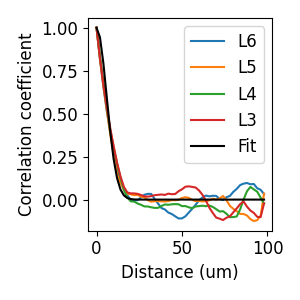

In [56]:
plt.figure(figsize=(3,3))
for layer in range(4):
    plt.plot(distances,mean_per_layer[layer])
    # lowerbound = scipy.stats.t.ppf(0.05,9,mean_per_layer[layer],sem_per_layer[layer])
    # upperbound = scipy.stats.t.ppf(0.95,9,mean_per_layer[layer],sem_per_layer[layer])
    # plt.fill_between(distances,lowerbound,upperbound,color='C'+str(layer),alpha=0.3)

plt.plot(distances,gaussian(distances,sigma[0]),'k')

plt.legend(['L6','L5','L4','L3','Fit'])
plt.xlabel('Distance (um)')
plt.ylabel('Correlation coefficient')
plt.tight_layout()

plt.savefig('../../figures/correlation.png',dpi=300)

In [29]:
np.where(distances==20)

(array([10]),)

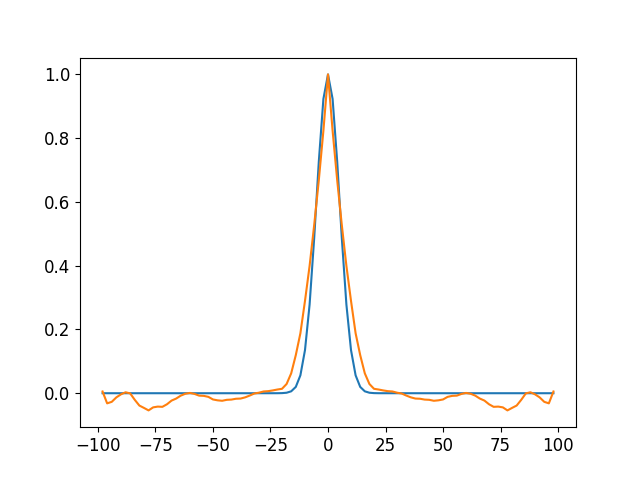

In [55]:
plt.figure()
plt.plot(newDistances,gaussian(newDistances,5))
plt.plot(newDistances,newValues)

In [16]:
sigma

(array([0.39896976]), array([[0.005806]]))

(10, 50)

In [10]:
np.array(correlations_stim).shape

(4, 10, 50, 50)

In [45]:
np.corrcoef(averagedSignals_rest[layer][trial]).shape

(50, 50)

In [51]:
np.array(averagedSignals_rest[layer][trial]).shape

(50, 100)

In [6]:
signals[0][0].shape

(50, 1000)

Text(0, 0.5, 'Signal (mV)')

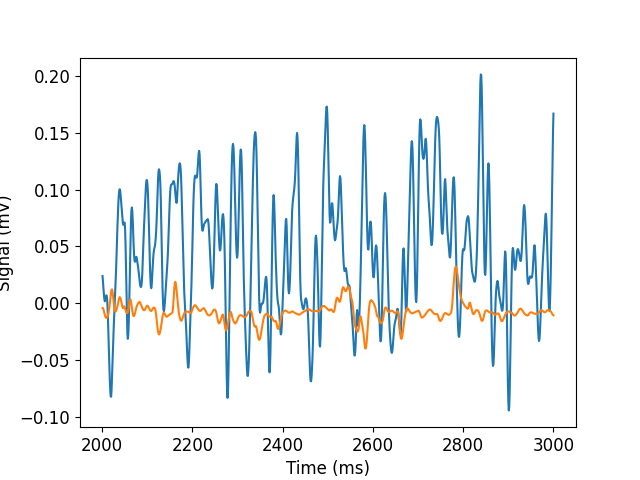

In [7]:
plt.figure()
time = np.linspace(0,3000,3000)
plt.plot(time[2000:],signals[1][2][20])
plt.plot(time[2000:],signals[1][1][24])
plt.xlabel('Time (ms)')
plt.ylabel('Signal (mV)')

In [8]:
xf

NameError: name 'xf' is not defined

In [ ]:
from scipy.fft import fft, fftfreq

plt.figure()

for layer in range(4):

    yf = fft(correlations[layer][20]-np.mean(correlations[layer][20]))
    N = len(correlations[layer][20])
    xf = fftfreq(N,10)[:N//2]
    plt.plot(1/xf[1:], 2.0/N * np.abs(yf[1:N//2]))

plt.xlim([20,200])
plt.tight_layout()

In [ ]:
signals = []
correlations = []
averagedSignals = []
averagedCorrelations = []

for layer in range(4):
    
    signals.append([])
    averagedSignals.append([])
    
    for electrode in range(40):
        
        signals[layer].append(totalL[2000:2050,layer*40+electrode])

        averagedSignal = totalL[:,layer*40+electrode]

        N = 10

        averagedSignal = np.convolve(averagedSignal, np.ones(N)/N, mode='valid')

        averagedSignals[layer].append(averagedSignal)
        

    signals[layer] = np.array(signals[layer])
    

    correlations.append(np.corrcoef(signals[layer]))
    averagedCorrelations.append(np.corrcoef(averagedSignals[layer]))

plt.figure()
plt.title('Correlations in evoked response')
for layer in range(4):
    plt.plot(10*np.arange(-20,20),correlations[layer][20])

plt.legend(['L6','L5','L4','L3'])
plt.xlabel('Distance (um)')
plt.ylabel('Correlation coefficient')

plt.xlim([-100,100])
plt.tight_layout()
plt.show()

In [ ]:
signals = []
correlations = []
averagedSignals = []
averagedCorrelations = []

for layer in range(4):
    
    signals.append([])
    averagedSignals.append([])
    
    for electrode in range(40):
        
        signals[layer].append(totalL[2450:2500,layer*40+electrode])

        averagedSignal = totalL[:,layer*40+electrode]

        N = 10

        averagedSignal = np.convolve(averagedSignal, np.ones(N)/N, mode='valid')

        averagedSignals[layer].append(averagedSignal)
        

    signals[layer] = np.array(signals[layer])
    

    correlations.append(np.corrcoef(signals[layer]))
    averagedCorrelations.append(np.corrcoef(averagedSignals[layer]))

plt.figure()
plt.title('Correlations in resting state')
for layer in range(4):
    plt.plot(10*np.arange(-20,20),correlations[layer][20])

plt.legend(['L6','L5','L4','L3'])
plt.xlabel('Distance (um)')
plt.ylabel('Correlation coefficient')

plt.xlim([-100,100])
plt.tight_layout()
plt.show()

In [ ]:
plt.figure()
for layer in range(4):
    plt.plot(10*np.arange(-20,20),averagedCorrelations[layer][20])

plt.legend(['L6','L5','L4','L3'])
plt.xlabel('Distance (um)')
plt.ylabel('Correlation coefficient')

plt.xlim([-100,100])
plt.tight_layout()
plt.show()

In [ ]:
totalL.shape


In [ ]:
import h5py
f = h5py.File('/gpfs/bbp.cscs.ch/project/proj68/scratch/tharayil/newCoeffs/b3122c45-e2d9-4205-821c-88f28791dc69/0/neuropixels/coeffsneuropixels.h5')


In [ ]:
electrodePos = []
for e in np.arange(51):
    electrodePos.append(f['electrodes']['Neuropixels-384_'+str(e)]['location'][:])
    
electrodePos = np.array(electrodePos)

In [ ]:
np.linalg.norm(electrodePos[1]-electrodePos[0])

In [ ]:
layers = []

for i in range(51):
    
    l = str(f['electrodes']['Neuropixels-384_'+str(i)]['layer'][()])
    
    if l == "b'Outside'":
        
        layers.append('Outside')
        
    else:
    
        l = l.split('L')[-1]

        layers.append(int(l[0]))

In [29]:
f.close()

In [30]:
breaks = np.where(np.diff(layers)!=0)[0]

In [31]:
meanLfp = np.mean(totalL,axis=0)

In [32]:
totalL -= meanLfp

In [33]:
import bluepysnap as bp
s = bp.Simulation('0/simulation_config.json')
types = np.sort(list(s.circuit.nodes.property_values('mtype')))

In [9]:
time = np.arange(0,3000,1)

In [35]:
def plotFig(axes,csd,breaks,absmax=None):

    # for b in breaks:
    #     ax.plot([0,3000],[b,b],c='k')

    if absmax is None:
        absmax = np.max(np.abs(csd))/2
        plotCB = True
    else:
        plotCB = False
    
    im = ax.imshow(np.array(csd), origin='lower', vmin =-absmax,vmax=absmax, cmap='bwr_r', interpolation='gaussian')
    ax.axis(ax.axis('tight'))

    if plotCB:
        cb = plt.colorbar(im, ax=ax)
        cb.formatter.set_powerlimits((0,0))


    ax.set_yticklabels([])
    ax.set_xticklabels([])

    ax.set_xlim([2000,2050])

    
    
        

In [36]:
def plotFigResting(axes,csd,breaks,absmax=None):

    # for b in breaks:
    #     ax.plot([0,3000],[b,b],c='k')

    if absmax is None:
        absmax = np.max(np.abs(csd))/2
        plotCB = True
    else:
        plotCB = False
    
    im = ax.imshow(np.array(csd), origin='lower')#, vmin =-absmax,vmax=absmax, cmap='bwr_r', interpolation='gaussian')
    ax.axis(ax.axis('tight'))

    if plotCB:
        cb = plt.colorbar(im, ax=ax)
        cb.formatter.set_powerlimits((0,0))


    ax.set_yticklabels([])
    ax.set_xticklabels([])

    ax.set_xlim([2450,2500])


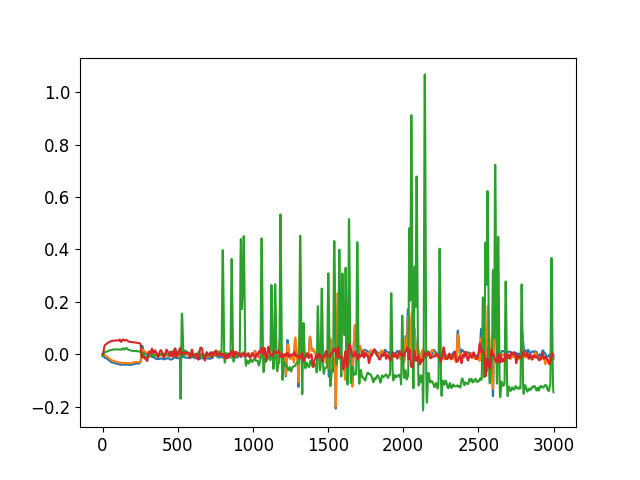

In [42]:
plt.figure()
plt.plot(time,totalL[:,20])
plt.plot(time,totalL[:,21])
plt.plot(time,totalL[:,22])
plt.plot(time,totalL[:,23])

Text(0.5, 1.0, 'Objective, \ndisk')

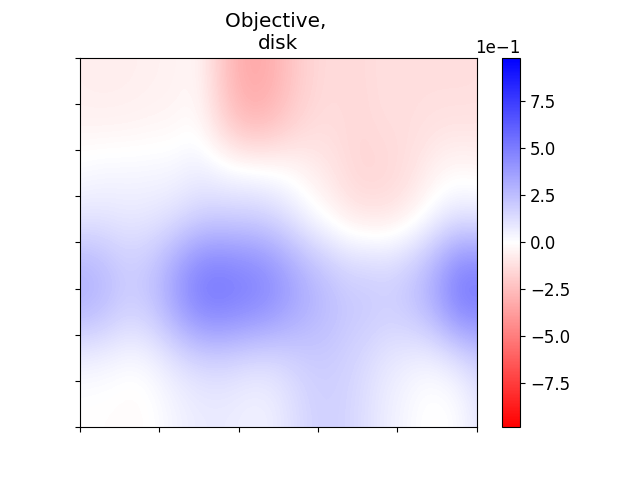

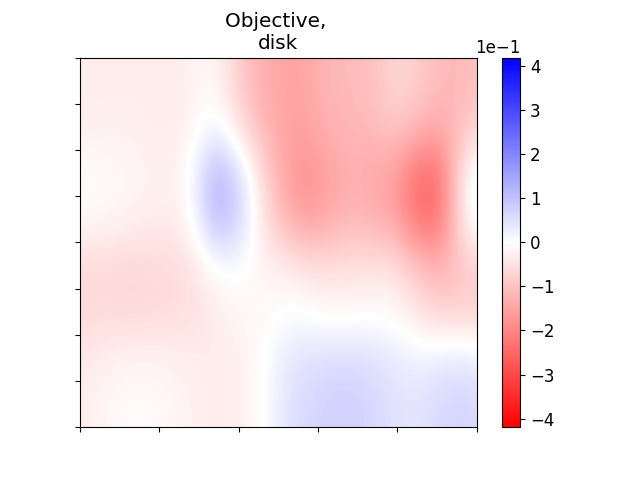

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)
csd = totalL[:,20:161:40].T
plotFig(ax,csd,breaks)
ax.set_title('Objective, \ndisk')

fig = plt.figure()
ax = fig.add_subplot(111)
csd = totalL[:,25:161:40].T
plotFig(ax,csd,breaks)
ax.set_title('Objective, \ndisk')

/gpfs/bbp.cscs.ch/home/tharayil/conntilitEnv/lib/python3.11/site-packages/quantities/quantity.py:341: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(other, self)


discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]


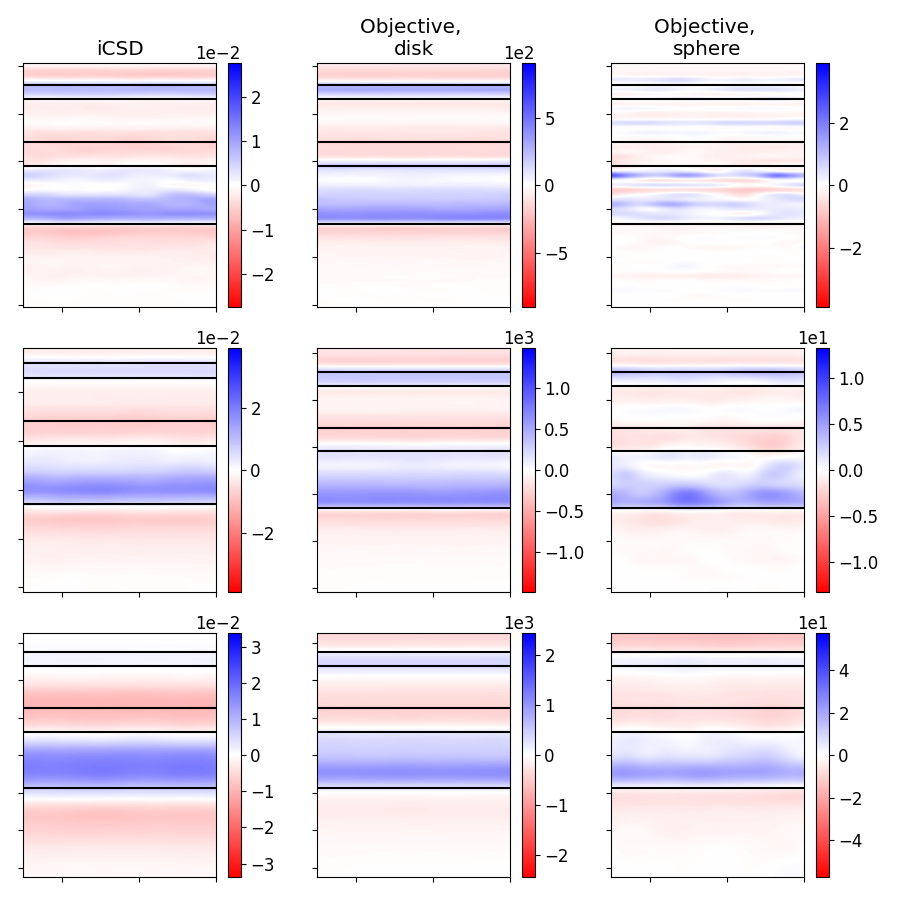

In [48]:
from scipy import io
import quantities as pq
import matplotlib.colors as colors

fig, axes = plt.subplots(3,3,figsize=(9,9))

lfp_data = totalLFP.T * 1E-3 * pq.V        # [mV] -> [V]


z_data = np.arange(0,51) * 1e-6 * pq.m
#z_data = np.linspace(0, 2000E-6, 50) * pq.m  # [m]
diam = 20E-6 * pq.m                              # [m]
h = 1E-6 * pq.m                                 # [m]
sigma = 0.277 * pq.S / pq.m                         # [S/m] or [1/(ohm*m)]
sigma_top = 0.277 * pq.S / pq.m                     # [S/m] or [1/(ohm*m)]

# Input dictionaries for each method

std_input = {
    'lfp' : lfp_data,
    'coord_electrode' : z_data,
    'sigma' : sigma,
    'f_type' : 'gaussian',
    'f_order' : (3, 1),
}
#Create the different CSD-method class instances. We use the class methods
#get_csd() and filter_csd() below to get the raw and spatially filtered
#versions of the current-source density estimates.
csd_dict = dict(
#     delta_icsd = DeltaiCSD(**delta_input),
#     step_icsd = StepiCSD(**step_input),
#     spline_icsd = SplineiCSD(**spline_input),
    std_csd = StandardCSD(**std_input),
)

for method, csd_obj in csd_dict.items():
    
    
    
    ax = axes[0][0]
        
    #plot raw csd estimate
    csd = csd_obj.get_csd()
    csd = csd_obj.filter_csd(csd)

    plotFigResting(ax,csd,breaks)
    ax.set_title('iCSD')


ax = axes[0][1]
csd = objective_disk_full.T
plotFigResting(ax,csd,breaks)
ax.set_title('Objective, \ndisk')

ax = axes[0][2]
csd = objective_sphere_full.T
plotFigResting(ax,csd,breaks)
ax.set_title('Objective, \nsphere')

lfp_data = totalLFP[:,0:-1:2].T * 1E-3 * pq.V        # [mV] -> [V]

z_data = np.arange(0,51,2) * 1e-6 * pq.m
#z_data = np.linspace(0, 2000E-6, 50) * pq.m  # [m]
diam = 40E-6 * pq.m                              # [m]


# Input dictionaries for each method

std_input = {
    'lfp' : lfp_data,
    'coord_electrode' : z_data,
    'sigma' : sigma,
    'f_type' : 'gaussian',
    'f_order' : (3, 1),
}
#Create the different CSD-method class instances. We use the class methods
#get_csd() and filter_csd() below to get the raw and spatially filtered
#versions of the current-source density estimates.
csd_dict = dict(
#     delta_icsd = DeltaiCSD(**delta_input),
#     step_icsd = StepiCSD(**step_input),
#     spline_icsd = SplineiCSD(**spline_input),
    std_csd = StandardCSD(**std_input),
)

for method, csd_obj in csd_dict.items():
    
    
    
    ax = axes[1][0]
        
    #plot raw csd estimate
    csd = csd_obj.get_csd()
    csd = csd_obj.filter_csd(csd)

    plotFigResting(ax,csd,breaks/2)


ax = axes[1][1]
csd = objective_disk_half.T
plotFigResting(ax,csd,breaks/2)

ax = axes[1][2]
csd = objective_sphere_half.T
plotFigResting(ax,csd,breaks/2)

lfp_data = totalLFP[:,0:-1:4].T * 1E-3 * pq.V        # [mV] -> [V]

z_data = np.arange(0,51,4) * 1e-6 * pq.m
#z_data = np.linspace(0, 2000E-6, 50) * pq.m  # [m]
diam = 80E-6 * pq.m                              # [m]


# Input dictionaries for each method

std_input = {
    'lfp' : lfp_data,
    'coord_electrode' : z_data,
    'sigma' : sigma,
    'f_type' : 'gaussian',
    'f_order' : (3, 1),
}
#Create the different CSD-method class instances. We use the class methods
#get_csd() and filter_csd() below to get the raw and spatially filtered
#versions of the current-source density estimates.
csd_dict = dict(
#     delta_icsd = DeltaiCSD(**delta_input),
#     step_icsd = StepiCSD(**step_input),
#     spline_icsd = SplineiCSD(**spline_input),
    std_csd = StandardCSD(**std_input),
)

for method, csd_obj in csd_dict.items():
    
    
    
    ax = axes[2][0]
        
    #plot raw csd estimate
    csd = csd_obj.get_csd()
    csd = csd_obj.filter_csd(csd)

    plotFigResting(ax,csd,breaks/4)


ax = axes[2][1]
csd = objective_disk_quarter.T
plotFigResting(ax,csd,breaks/4)

ax = axes[2][2]
csd = objective_sphere_quarter.T
plotFigResting(ax,csd,breaks/4)


plt.tight_layout()
plt.show()

In [26]:
lfp_data.shape

(13, 300)

/gpfs/bbp.cscs.ch/home/tharayil/conntilitEnv/lib/python3.11/site-packages/quantities/quantity.py:341: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(other, self)


discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.

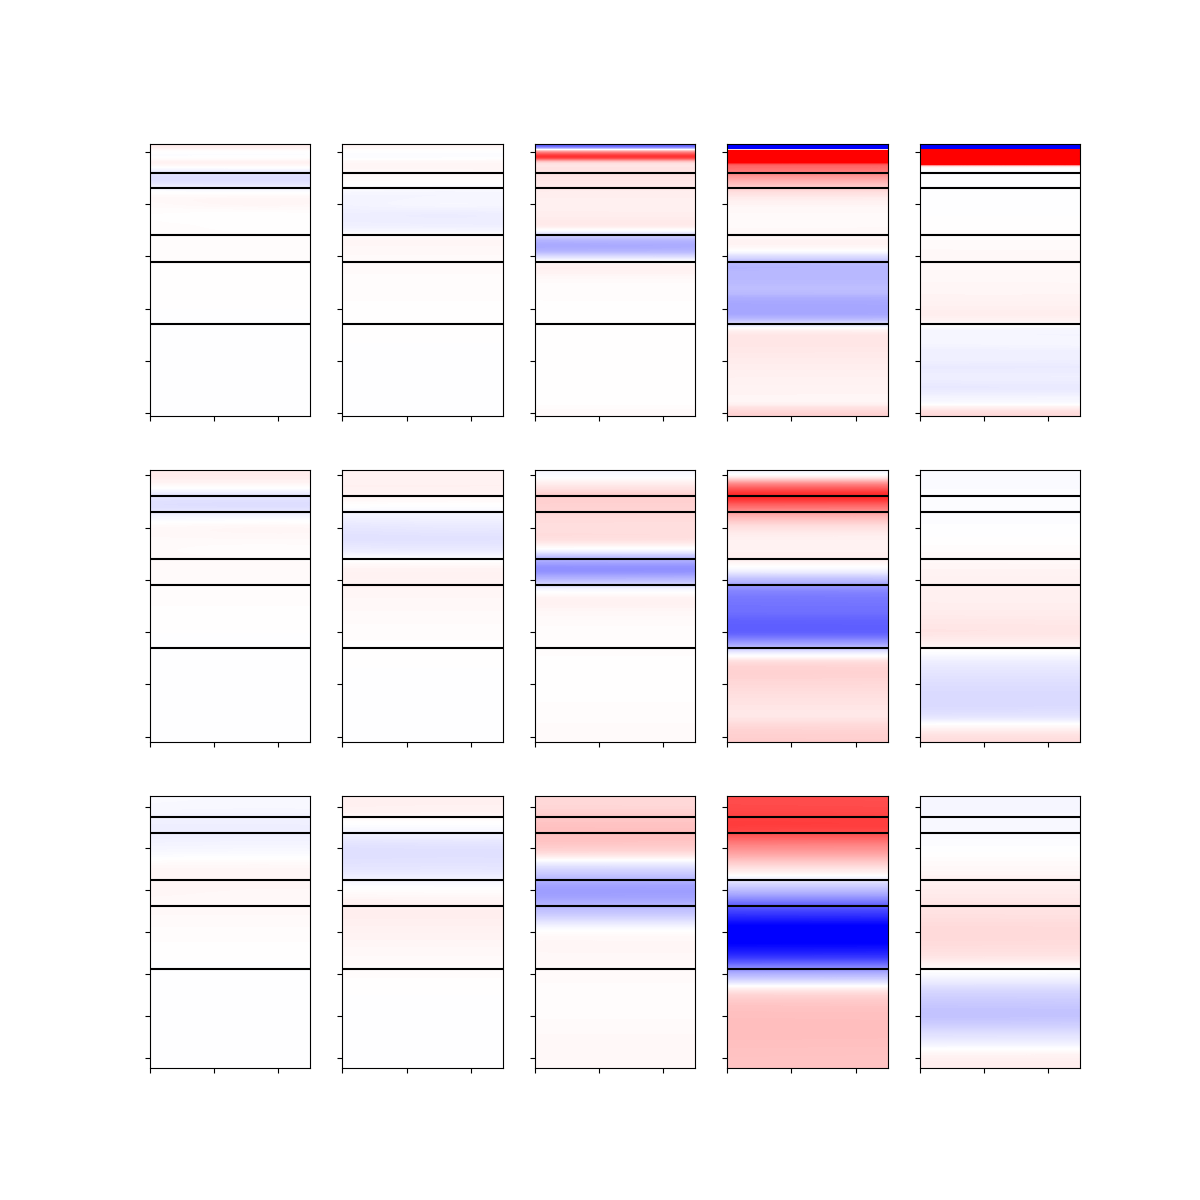

In [24]:
from scipy import io
import quantities as pq
import matplotlib.colors as colors

originalbreaks = breaks

fig, axes = plt.subplots(3,5,figsize=(12,12))

for j in range(3):

    for i in np.arange(2,7):    

        if j == 0:
            lfp_data = byLayer[i].T * 1E-3 * pq.V
            breaks = originalbreaks
            z_data = np.arange(0,51) * 1e-6 * pq.m
        elif j == 1:
            lfp_data = byLayer[i][:,0:-1:2].T * 1E-3 * pq.V
            breaks = originalbreaks/2
            z_data = np.arange(0,51,2) * 1e-6 * pq.m
        else:
            lfp_data = byLayer[i][:,0:-1:4].T * 1E-3 * pq.V
            breaks = originalbreaks/4
            z_data = np.arange(0,51,4) * 1e-6 * pq.m
        
        diam = 20E-6 * pq.m                              # [m]
        h = 1E-6 * pq.m                                 # [m]
        sigma = 0.277 * pq.S / pq.m                         # [S/m] or [1/(ohm*m)]
        sigma_top = 0.277 * pq.S / pq.m                     # [S/m] or [1/(ohm*m)]
    
        # Input dictionaries for each method
    
        std_input = {
            'lfp' : lfp_data,
            'coord_electrode' : z_data,
            'sigma' : sigma,
            'f_type' : 'gaussian',
            'f_order' : (3, 1),
        }
        #Create the different CSD-method class instances. We use the class methods
        #get_csd() and filter_csd() below to get the raw and spatially filtered
        #versions of the current-source density estimates.
        csd_dict = dict(
            std_csd = StandardCSD(**std_input),
        )
    
        for method, csd_obj in csd_dict.items():
    
            #plot raw csd estimate
            csd = csd_obj.get_csd()
            csd = csd_obj.filter_csd(csd)
            
            ax = axes[j][i-2]
            
            plotFig(ax,csd,breaks,2.5e-2)
    

        breaks = originalbreaks
    
        # plt.tight_layout()
        # plt.show()
    


/gpfs/bbp.cscs.ch/home/tharayil/conntilitEnv/lib/python3.11/site-packages/quantities/quantity.py:341: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(other, self)
/gpfs/bbp.cscs.ch/home/tharayil/conntilitEnv/lib/python3.11/site-packages/quantities/quantity.py:341: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(other, self)
/gpfs/bbp.cscs.ch/home/tharayil/conntilitEnv/lib/python3.11/site-packages/quantities/quantity.py:341: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(other, self)
/gpfs/bbp.cscs.ch/home/tharayil/conntilitEnv/lib/python3.11/site-packages/quantities/quantity.py:341: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(other, self)


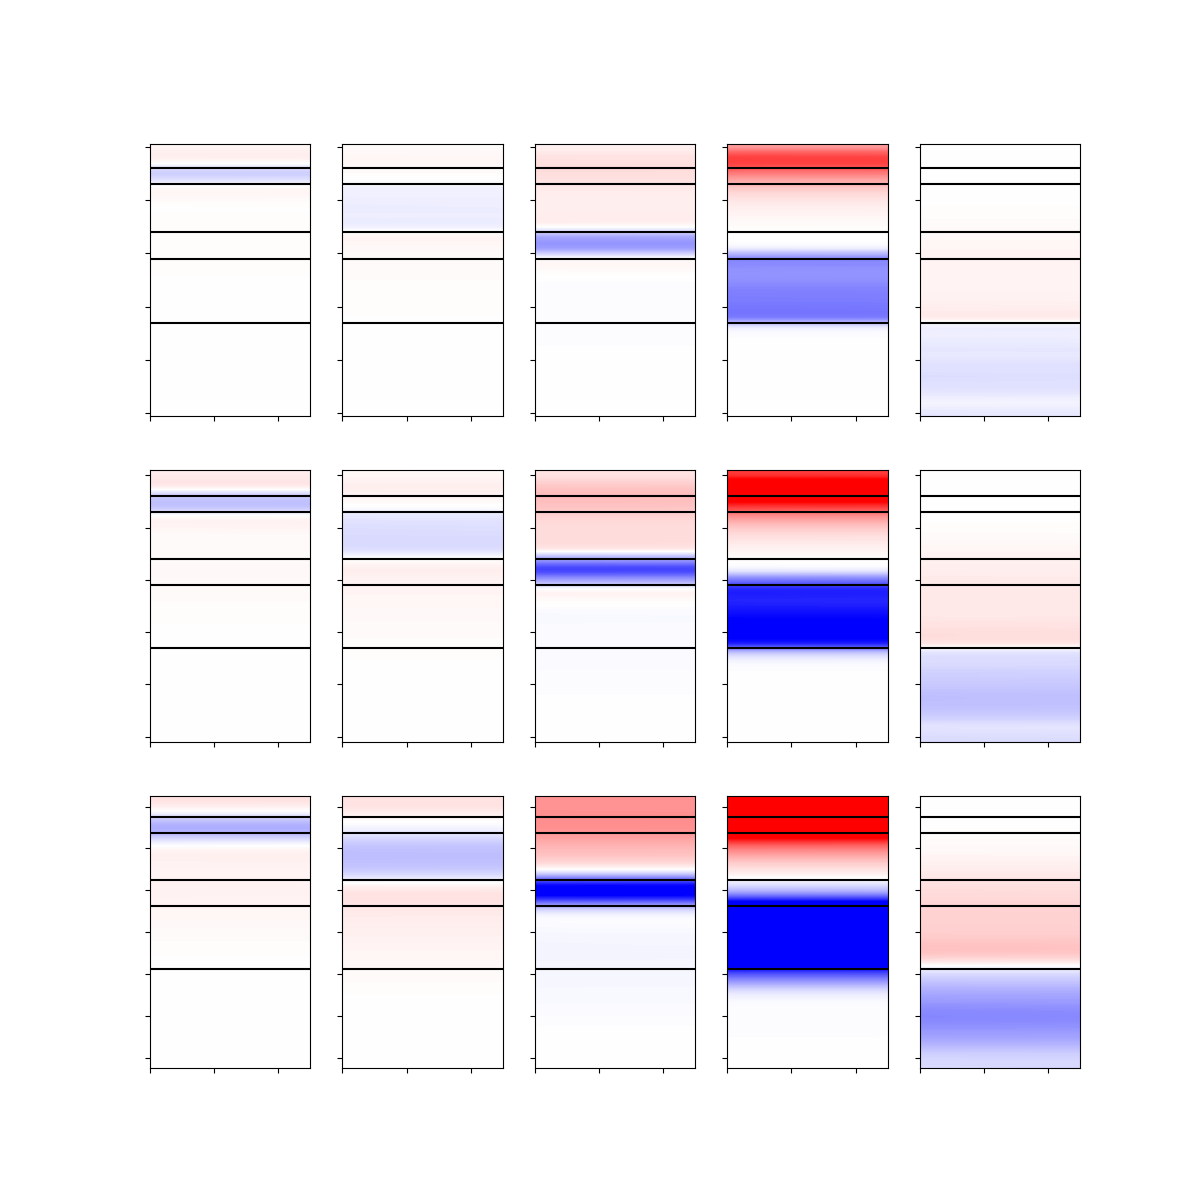

In [25]:
from scipy import io
import quantities as pq
import matplotlib.colors as colors

originalbreaks = breaks

fig, axes = plt.subplots(3,5,figsize=(12,12))

for j in range(3):

    for i in np.arange(2,7):    

        if j == 0:
            lfp_data = byLayer_objective_disk_full[i].T * 1E-3 * pq.V
            breaks = originalbreaks
            z_data = np.arange(0,51) * 1e-6 * pq.m
            absmax = 6e-1
        elif j == 1:
            lfp_data = byLayer_objective_disk_half[i].T * 1E-3 * pq.V
            breaks = originalbreaks/2
            z_data = np.arange(0,51,2) * 1e-6 * pq.m
            absmax = 6e-1
        else:
            lfp_data = byLayer_objective_disk_quarter[i].T * 1E-3 * pq.V
            breaks = originalbreaks/4
            z_data = np.arange(0,51,4) * 1e-6 * pq.m
        
        diam = 20E-6 * pq.m                              # [m]
        h = 1E-6 * pq.m                                 # [m]
        sigma = 0.277 * pq.S / pq.m                         # [S/m] or [1/(ohm*m)]
        sigma_top = 0.277 * pq.S / pq.m                     # [S/m] or [1/(ohm*m)]
    
        # Input dictionaries for each method
    
        std_input = {
            'lfp' : lfp_data,
            'coord_electrode' : z_data,
            'sigma' : sigma,
            'f_type' : 'gaussian',
            'f_order' : (3, 1),
        }
        #Create the different CSD-method class instances. We use the class methods
        #get_csd() and filter_csd() below to get the raw and spatially filtered
        #versions of the current-source density estimates.
        csd_dict = dict(
            std_csd = StandardCSD(**std_input),
        )
    
        for method, csd_obj in csd_dict.items():
    
            #plot raw csd estimate
            csd = lfp_data
            
            ax = axes[j][i-2]
            
            plotFig(ax,csd,breaks,absmax)
    

        breaks = originalbreaks
    
        # plt.tight_layout()
        # plt.show()
    


/gpfs/bbp.cscs.ch/home/tharayil/conntilitEnv/lib/python3.11/site-packages/quantities/quantity.py:341: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(other, self)
/gpfs/bbp.cscs.ch/home/tharayil/conntilitEnv/lib/python3.11/site-packages/quantities/quantity.py:341: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(other, self)
/gpfs/bbp.cscs.ch/home/tharayil/conntilitEnv/lib/python3.11/site-packages/quantities/quantity.py:341: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(other, self)


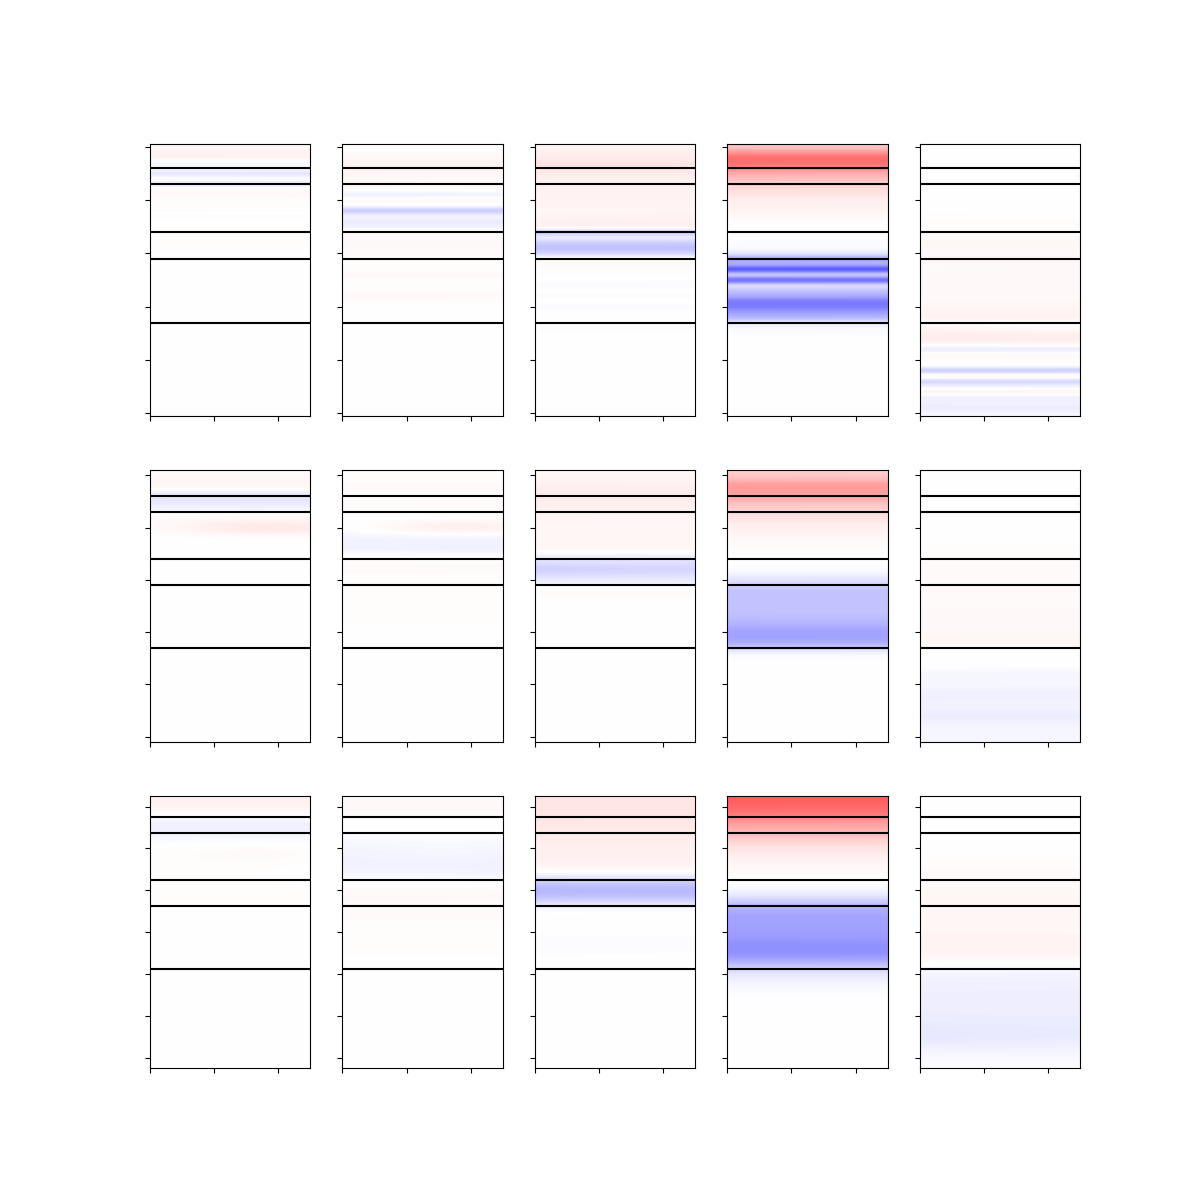

In [26]:
from scipy import io
import quantities as pq
import matplotlib.colors as colors

originalbreaks = breaks

fig, axes = plt.subplots(3,5,figsize=(12,12))

for j in range(3):

    for i in np.arange(2,7):    

        if j == 0:
            lfp_data = byLayer_objective_sphere_full[i].T * 1E-3 * pq.V
            breaks = originalbreaks
            z_data = np.arange(0,51) * 1e-6 * pq.m
            absmax = 1e-3
        elif j == 1:
            lfp_data = byLayer_objective_sphere_half[i].T * 1E-3 * pq.V
            breaks = originalbreaks/2
            z_data = np.arange(0,51,2) * 1e-6 * pq.m
            absmax = 1e-2
        else:
            lfp_data = byLayer_objective_sphere_quarter[i].T * 1E-3 * pq.V
            breaks = originalbreaks/4
            z_data = np.arange(0,51,4) * 1e-6 * pq.m
            absmax = 5e-2
        
        diam = 20E-6 * pq.m                              # [m]
        h = 1E-6 * pq.m                                 # [m]
        sigma = 0.277 * pq.S / pq.m                         # [S/m] or [1/(ohm*m)]
        sigma_top = 0.277 * pq.S / pq.m                     # [S/m] or [1/(ohm*m)]
    
        # Input dictionaries for each method
    
        std_input = {
            'lfp' : lfp_data,
            'coord_electrode' : z_data,
            'sigma' : sigma,
            'f_type' : 'gaussian',
            'f_order' : (3, 1),
        }
        #Create the different CSD-method class instances. We use the class methods
        #get_csd() and filter_csd() below to get the raw and spatially filtered
        #versions of the current-source density estimates.
        csd_dict = dict(
            std_csd = StandardCSD(**std_input),
        )
    
        for method, csd_obj in csd_dict.items():
    
            #plot raw csd estimate
            csd = lfp_data
            
            ax = axes[j][i-2]
            
            plotFig(ax,csd,breaks,absmax)
    

        breaks = originalbreaks
    
        # plt.tight_layout()
        # plt.show()
    
